In [1]:
import lib.evaluation as ev
import lib.plotting as plot
import lib.dataset as dt
import models

import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from sklearn.metrics import roc_curve, auc
from importlib import reload

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
# Read small datasets
train = 'small_6000-TRAIN-83.csv'
val = 'small_6000-VALIDATION-09.csv'
test = 'small_6000-TEST-08.csv'

train_dataset, y_true_train = dt.create_dataset(train, num_classes=3, apply_data_augmentation=True, batch_size=4, prefetch_buffer=2, shuffle=True)

val_dataset, y_true_val = dt.create_dataset(val, num_classes=3, prefetch_buffer=2)

test_dataset, y_true_test = dt.create_dataset(test, num_classes=3, prefetch_buffer=2)

In [4]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_true_train[:,:-1], axis=1)

In [10]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weights

array([0.45035269, 4.46236559, 1.80043384])

In [11]:
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.4503526858383071, 1: 4.462365591397849, 2: 1.8004338394793926}

In [13]:
## Another training
# With class weighs

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

####################################################################

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_true_train[:,0]),
                                                  y=y_true_train[:,0])

# Convert to dictionary -- requeriment for keras fit function
class_weights = {class_: weight for class_, weight in enumerate(class_weights)}
print(class_weights)

{0: 0.611947547353084, 1: 2.7331887201735356}


In [14]:
# Compile
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              metrics=['acc', 
                       tf.keras.metrics.AUC(summation_method='minoring')]) 
                       # 'minoring' applies left summation for increasing intervals and right summation for decreasing intervals

In [15]:
# Train
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, class_weight=class_weights)

Epoch 1/30
315/315 [==============================] - 107s 340ms/step - loss: 0.9703 - acc: 0.4687 - auc: 0.5124 - val_loss: 0.5908 - val_acc: 0.8250 - val_auc: 0.5644
Epoch 2/30
315/315 [==============================] - 106s 337ms/step - loss: 0.7217 - acc: 0.5520 - auc: 0.5711 - val_loss: 0.6085 - val_acc: 0.8104 - val_auc: 0.6544
Epoch 3/30
315/315 [==============================] - 106s 338ms/step - loss: 0.6476 - acc: 0.6819 - auc: 0.6912 - val_loss: 0.7024 - val_acc: 0.6396 - val_auc: 0.7856
Epoch 4/30
315/315 [==============================] - 106s 337ms/step - loss: 0.6165 - acc: 0.7187 - auc: 0.7244 - val_loss: 0.6139 - val_acc: 0.6792 - val_auc: 0.8088
Epoch 5/30
315/315 [==============================] - 106s 337ms/step - loss: 0.5729 - acc: 0.7435 - auc: 0.7688 - val_loss: 0.4482 - val_acc: 0.8354 - val_auc: 0.7883
Epoch 6/30
315/315 [==============================] - 106s 337ms/step - loss: 0.5492 - acc: 0.7730 - auc: 0.7919 - val_loss: 0.4830 - val_acc: 0.8062 - val_auc:

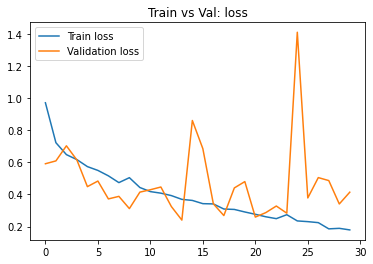

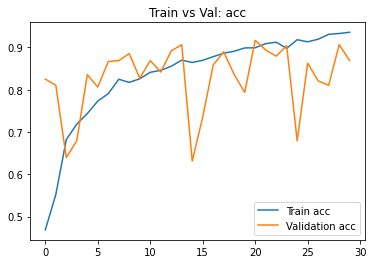

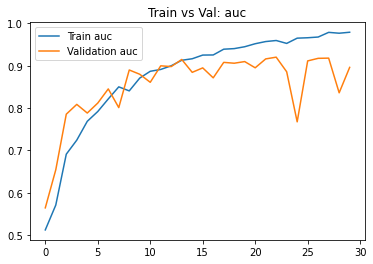

In [16]:
# Plot metrics
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'acc')
plot.plot_metric(history, 'auc')

In [7]:
# Validation predictions
y_pred_val = model.predict(val_dataset).ravel()

# Test predictions
y_pred_test = model.predict(test_dataset).ravel()

In [8]:
# Get ROC curves for validation and test sets
fpr_val, tpr_val, th_val = ev.get_roc_curve(y_true_val[:,0], y_pred_val)

fpr_test, tpr_test, th_test = ev.get_roc_curve(y_true_test[:,0], y_pred_test)

# Closest point to Up-Left corner in validation dataset
val_closest = ev.get_closest_point_to_01(fpr_val, tpr_val)
# Get threshold
thr_val_closest = th_val[val_closest]

In [11]:
# DR levels existing on validation dataset
dr_levels = np.sort(np.unique(y_true_val[np.where(y_true_val[:,0] == 1), 1]))

# Get a classification for each DR level vs rest
dr_classifications = tuple(np.where(y_true_val[:,1] == current_dr, 1, 0) for current_dr in dr_levels)

# Sensibility operative points 
operative_points = [98, 95, 93, 90, 85]

results_val = ev.get_results_at_operative_points(fpr_val,
                                                 tpr_val,
                                                 th_val,
                                                 y_true_val[:,0],
                                                 y_pred_val,
                                                 dr_levels,
                                                 dr_classifications,
                                                 operative_points,
                                                 operative_thresholds=[thr_val_closest])

results_val.style.set_caption("Validation dataset - Results - AUC: " + str(round(ev.get_auc(fpr_val, tpr_val), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_2,FNR_3,FNR_4,Thresholds
0,98,98.800000,19.400000,1.200000,1.640000,0.000000,0.000000,0.002217
1,95,95.180000,52.140000,4.820000,6.560000,0.000000,0.000000,0.023684
2,93,93.980000,52.140000,6.020000,8.200000,0.000000,0.000000,0.024547
3,90,90.360000,65.240000,9.640000,13.110000,0.000000,0.000000,0.056231
4,85,85.540000,80.600000,14.460000,19.670000,0.000000,0.000000,0.213422
5,Closest point,83.130000,84.380000,16.870000,21.310000,0.000000,12.500000,0.289520


In [12]:
# DR levels existing on test dataset
dr_levels = np.sort(np.unique(y_true_test[np.where(y_true_test[:,0] == 1), 1]))

# Get a classification for each DR level vs rest
dr_classifications = tuple(np.where(y_true_test[:,1] == current_dr, 1, 0) for current_dr in dr_levels)

# Get results using thresholds of validation dataset
results_test = ev.get_results_at_operative_points(fpr_test,
                                                  tpr_test,
                                                  th_test,
                                                  y_true_test[:,0],
                                                  y_pred_test,
                                                  dr_levels,
                                                  dr_classifications,
                                                  operative_thresholds=results_val['Thresholds'].tolist())

# Add sensibility points column
results_test.insert(0, 'Sens. Operative point', results_val['Sens. Operative point'])

results_test.style.set_caption("Test dataset - Results - AUC: " + str(round(ev.get_auc(fpr_test, tpr_test), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_2,FNR_3,FNR_4,Thresholds
0,98,97.000000,21.840000,3.000000,3.700000,0.000000,0.000000,0.002217
1,95,94.000000,56.320000,6.000000,7.410000,0.000000,0.000000,0.023684
2,93,93.000000,56.580000,7.000000,8.640000,0.000000,0.000000,0.024547
3,90,89.000000,70.260000,11.000000,13.580000,0.000000,0.000000,0.056231
4,85,85.000000,83.950000,15.000000,18.520000,0.000000,0.000000,0.213422
5,Closest point,85.000000,88.680000,15.000000,18.520000,0.000000,0.000000,0.289520


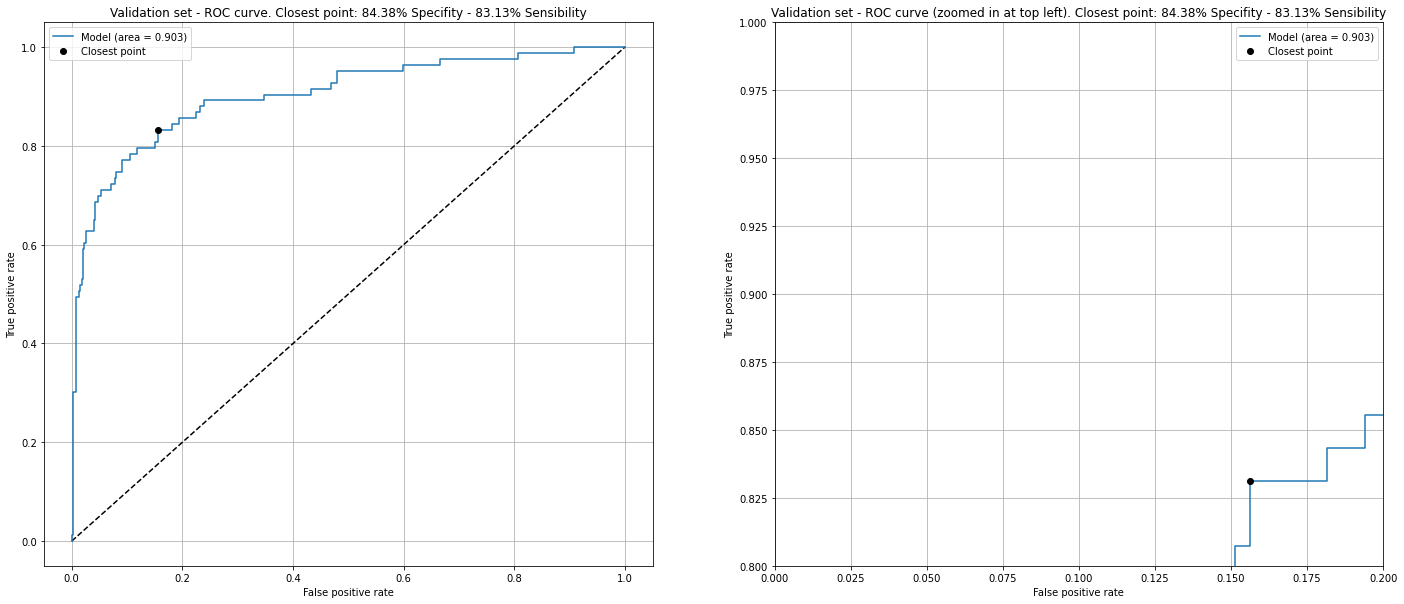

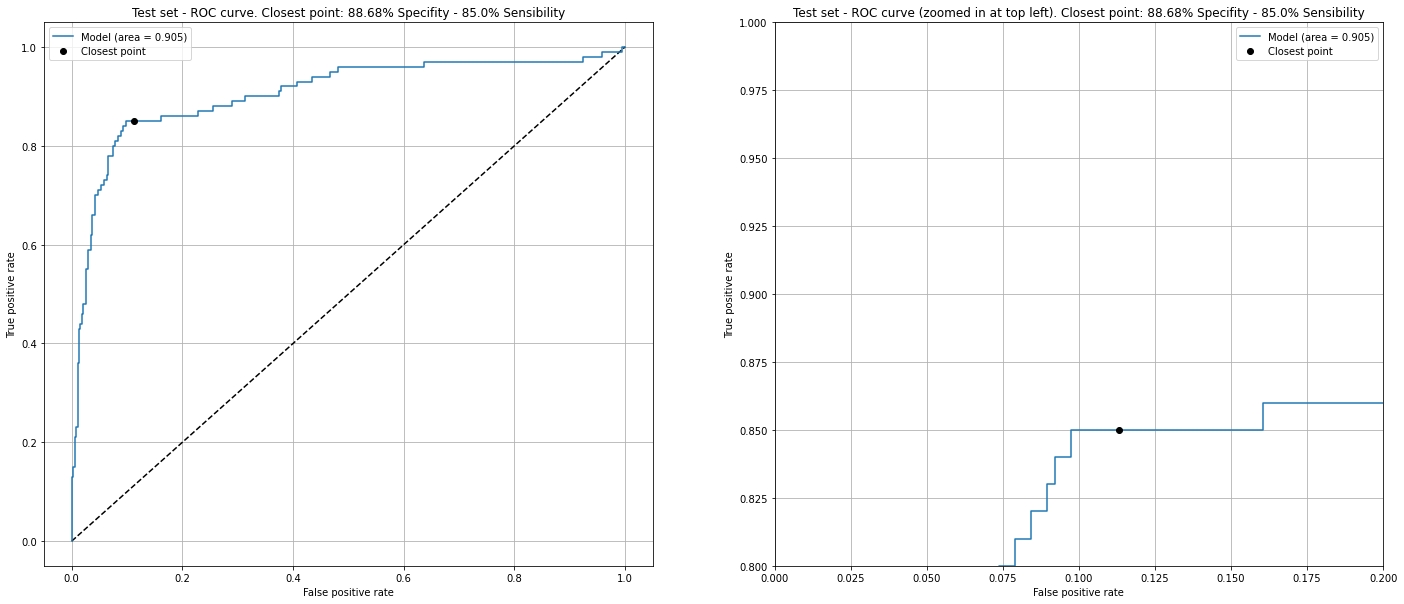

In [13]:
# Plot ROC curves
operating_threshold = plot.plot_roc_curve(tpr_val, fpr_val, th_val, 'Model', 'Validation set', True)

# Add operating threshold to test thresholds if it does not exist 
fpr_test, tpr_test, th_test, _ = ev.add_threshold_to_roc(fpr_test, tpr_test, th_test, y_true_test[:,0], y_pred_test, operating_threshold)

_ = plot.plot_roc_curve(tpr_test, fpr_test, th_test, 'Model', 'Test set', True, operating_threshold)

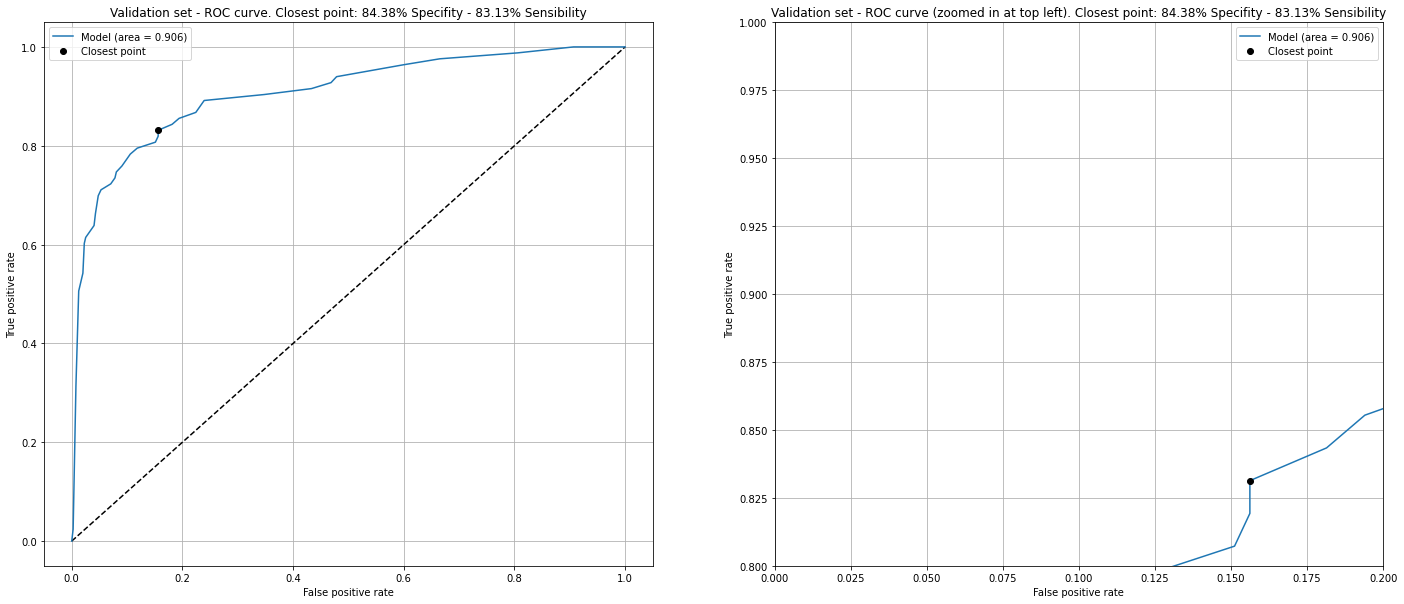

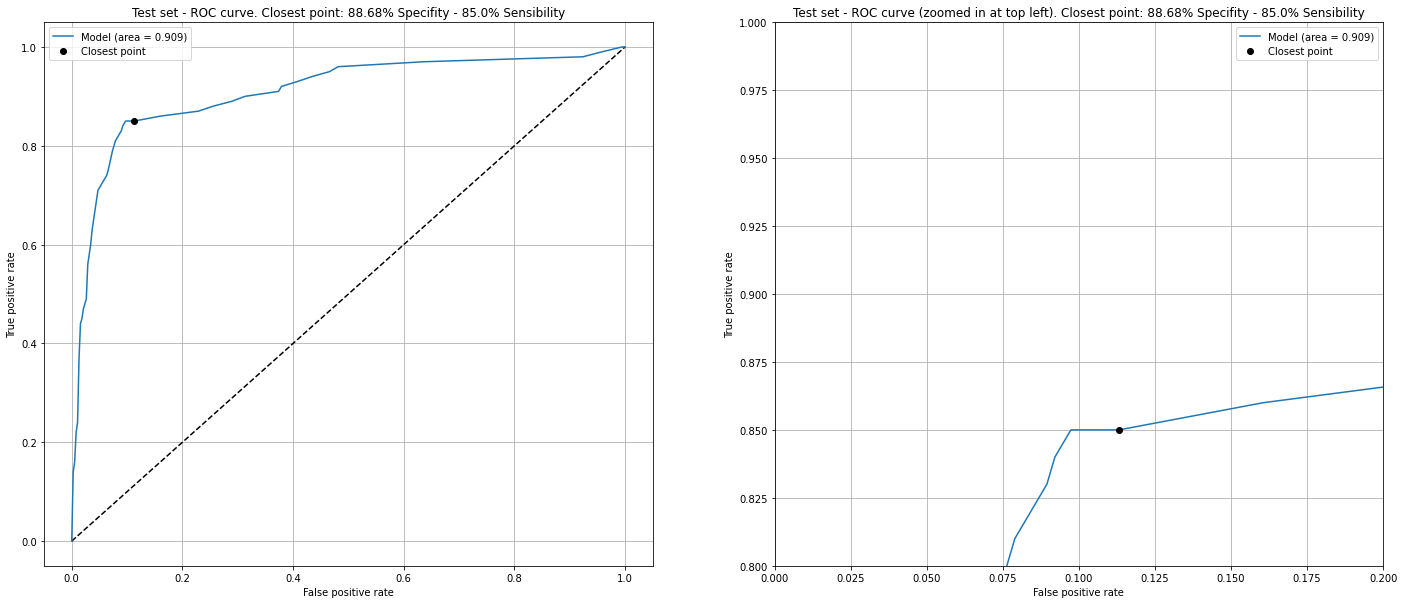

In [14]:
# Plot ROC curves ignoring useless points
operating_threshold = plot.plot_roc_curve(tpr_val, fpr_val, th_val, 'Model', 'Validation set', True, ignore=True)

# Add operating threshold to test thresholds if it does not exist 
fpr_test, tpr_test, th_test, _ = ev.add_threshold_to_roc(fpr_test, tpr_test, th_test, y_true_test[:,0], y_pred_test, operating_threshold)

_ = plot.plot_roc_curve(tpr_test, fpr_test, th_test, 'Model', 'Test set', True, operating_threshold, ignore=True)

In [24]:
# Save model weights
model.save_weights(save_path)